In [ ]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import plotly.express as px
import pandas as pd
from scipy.special import expit as sigmoid

# **Implementación y pruebas en casos sintéticos**

## **Clasificador de cuadrados mínimos**

1.   Implementar un clasficador cuadrático para $K$ clases.
2.   Aplicarlo a la clasificación de 3 clases en $\mathbb{R}^{2}$.

In [ ]:
# K = cantidad de clases a crear, n = cantidad de puntos por clase, d = dispersción de los datos, medias = vector de medias de las clases crear.
def generador_puntos_clases(K, n, d, medias):
	unitaria = np.eye(K)
	cov = np.array([[d**2, 0], [0, d**2]])

	X, T = np.array([]), np.array([])
	for c in range(K):
		media = np.array(medias[c])
		X = np.append(X, np.random.multivariate_normal(media, cov, size=n))
		T = np.append(T, np.ones((n, K)) * unitaria[c])

	return X.reshape((K*n, 2)), T.reshape((K*n), K)

def plot_puntos_clases(K, n, d, medias):
	X, T = generador_puntos_clases(K, n, d, medias)
	df = pd.DataFrame([{"clase": c, "x": X[i+ (n * c),0], "y": X[i + (n * c),1]} for i in range(n) for c in range(K)])
	f = px.scatter(df, x="x", y="y", color="clase", range_x=[0, 100], range_y=[0, 100])
	return df, X, T, f

def matriz_W(X, T): #Creo la matriz W
  X = np.append(np.ones(X.shape[0]), X.transpose()).reshape((X.shape[1]+1, X.shape[0])).transpose()
  psinv = np.linalg.pinv(X)
  return np.dot(psinv, T)

def y_predictor(W,x): #Funcion y(x)
	y_x = np.dot(W.transpose(), np.append([1], x).transpose()) # x lo transpongo porque es, por como lo genero, un vector fila.
	return y_x

def perceptron(y): #Pseudo perceptron, para quedarme solo con la clase a la que clasifica
	return np.argmax(y)

In [ ]:
np.random.seed(1000)

# Separacion estandar

medias = [[15.21542815, 73.84878608], [96.51774901, 61.24788919], [88.80294663, 70.20533919]]
d = 3

df, X, T, f = plot_puntos_clases(len(medias), 50, d, medias)
f.show()

_, X_test, T_test, f = plot_puntos_clases(len(medias), 50, d, medias)
f.show()

W = matriz_W(X, T)

mal_clasificados = 0
for x, t in zip(X_test, T_test):
  y = y_predictor(W, x)
  if perceptron(y) != perceptron(t):
    mal_clasificados += 1

print("Mal clasificados %d" % mal_clasificados)



Mal clasificados 11


In [ ]:
np.random.seed(1000)

medias = [[40, 40], [20, 20], [20, 40]]
d = 10

df, X, T, f = plot_puntos_clases(len(medias), 50, d, medias)
f.show()

_, X_test, T_test, f = plot_puntos_clases(len(medias), 50, d, medias)
f.show()

W = matriz_W(X, T)

mal_clasificados = 0
for x, t in zip(X_test, T_test):
  y = y_predictor(W, x)
  if perceptron(y) != perceptron(t):
    mal_clasificados += 1

print("Mal clasificados %d" % mal_clasificados)


Mal clasificados 44


## **Clasificador logística**



1.   Implementar regresión logística para separación lineal de 2 clases. Esto implica implementar el algoritmo iterativo para hallar el valor del vector de parámetros $w$ y $w_0$.
2.   Aplicarlo a la separación lineal de puntos en $\mathbb{R}^{2}$.
3.   Implementar regresión logística para separación “elíptica” de 2 clases. Esto implica implementar el algoritmo iterativo para hallar el valor del vector de parámetros $w$ y $w_0$ y plantear la ecuación de la transformación $\phi(x)$ correspondiente.
4.   Aplicarlo a la separación “elíptica” de puntos en $\mathbb{R}^{2}$.

In [ ]:
def phi_lineal(x):
  return np.append(np.array(x), [1])

np.random.seed(1000)

medias = [[20, 20], [25, 40]]
d = 10

df, X, T, f = plot_puntos_clases(len(medias), 50, d, medias)
# f.show()

_, X_test, T_test, f = plot_puntos_clases(len(medias), 50, d, medias)
f.show()

t = np.array(([0] * 50) + ([1] * 50)).reshape((100, 1))

from functools import partial

def clasificador_logistico(x, w, phi):
  return 1 if sigmoid(w.transpose() @ phi(x)) > 0.5 else 0

def get_clasificador_logistico(X, t, phi_function, maxiter=100, epsilon=0.0001):
  iter_info = []
  phi_function_vectorized = np.vectorize(phi_function)

  phi_matrix = np.array([phi_function(x) for x in X])
  phi_t_matrix = phi_matrix.transpose()

  w = np.random.rand(phi_matrix.shape[1], 1)
  w_last = w + np.ones_like(w)
  ones = np.ones_like(phi_matrix @ w) # ones_like(y)
  eps_compl = (1-epsilon)*ones
  eps = epsilon*ones
  i = 0
  while i < maxiter and np.linalg.norm(w - w_last, ord=math.inf) > epsilon:
    y = sigmoid(phi_matrix @ w)
    y = np.maximum(eps, np.minimum(eps_compl, y))
    R_diagonal = y * (ones - y)
    R = np.diag(R_diagonal.flat)
    try:
      r = np.linalg.inv(phi_t_matrix @ R @ phi_matrix)
    except np.linalg.LinAlgError:
      break
    
    iter_info.append({"iter": i, "w": w, "clasificador": partial(clasificador_logistico, w=w, phi=phi_function)})
    w_last = w
    w = w - (r @ phi_t_matrix @ (y - t))
    i += 1

  print(f"Done {i} iterations")

  return partial(clasificador_logistico, w=w, phi=phi_function), iter_info

final_logistic, iter_info = get_clasificador_logistico(X, t, phi_lineal, maxiter=1000)
test_color = []

for j, info in enumerate(iter_info):
  errores = 0
  if (j+1) % 10 != 0:
    continue
  logistic = info["clasificador"]
  for i, x in enumerate(X_test):
    estimacion = logistic(x)

    color = 'ok'

    clase = perceptron(T_test[i])
    if estimacion != clase:
      errores += 1
      color = 'error'

    test_color.append({"group": i,"x": x[0], "y":x[1], "clase": clase, "estimacion": estimacion, "clasificacion": color, "iter": j+1})

f = px.scatter(test_color, x="x", y="y", color="clasificacion", animation_frame="iter", animation_group="group", range_x=[0, 100], range_y=[0, 100])
f.show()

print(errores)

Done 1000 iterations


16


## **K-Means**

1.   Implementar k-means.
2.   Aplicarlo a un conjunto de Gaussianas con diferentes medias y covarianzas.



In [ ]:
def asignacion (centros, x):
  cluster = np.zeros(len(centros))
  cluster[0] = 1
  distancia = np.linalg.norm(x-centros[0]) 
  i = 0
  for c in centros:
    if distancia > np.linalg.norm(x-c): 
      distancia = np.linalg.norm(x-c) 
      cluster = np.zeros(len(centros))
      cluster[i] = 1
    i = i + 1
  return cluster

################################################################################

def k_means(X, K, maxiter=100, epsilon=0.0000000001): # X = datos, K = cantidad de clases 
  centros = []

  for i in range(K): # Inicializo los centros de los clusters aleatoriamente.
    centro = [np.random.randint(0, 80), np.random.randint(0, 80)]
    centros.append(centro)
  centros_last = centros + np.ones_like(centros)

  t = []
  for x in X: # Se asigna cada dato al cluster más cercano
    t_dato = asignacion(centros, x)
    t.append(t_dato)

  i = 0
  while i < maxiter and np.linalg.norm(np.array(centros) - np.array(centros_last), ord=math.inf) > epsilon:
    centros_last = centros
    centros = []
    for c in range(K): # Actualizo los centros
      count = 1
      suma1 = 0
      suma2 = 0
      j = 0
      for x in X:
        if t[j][c] == 1:
          suma1 = suma1 + x[0]
          suma2 = suma2 + x[1]
          count = count + 1
        j = j + 1
      suma1 = suma1/count
      suma2 = suma2/count
      centro = [suma1,suma2]
      if centro == [0,0]:
        centros.append([np.random.randint(0, 80), np.random.randint(0, 80)])
      else:  
        centros.append(centro)
    i = i + 1

    t = []
    for x in X: # Actualizo la asignacion de cada dato al cluster más cercano
      t_dato = asignacion(centros, np.array(x))
      t.append(t_dato)

  print(f"Done {i} iterations")

  return centros

In [ ]:
def clasificar_k_means(centros, x):
  distancias = [np.linalg.norm(np.array(x)-c) for c in centros]
  return np.argmin(distancias), np.min(distancias)

def mostrar_triclase(centros, X):
  for x_test in X:
    centro, _ = clasificar_k_means(centros, x_test)
    if centro == 0:
      plt.scatter(x_test[0], x_test[1], c="yellow")
    if centro == 1:
      plt.scatter(x_test[0], x_test[1], c="blue")
    if centro == 2:
      plt.scatter(x_test[0], x_test[1], c="red")

  plt.scatter(centros[0][0], centros[0][1], s=250, marker='^', c="black")
  plt.scatter(centros[1][0], centros[1][1], s=250, marker='^', c="black")
  plt.scatter(centros[2][0], centros[2][1], s=250, marker='^', c="black")

from itertools import permutations 
def mostrar_clasificacion(X, T, clases, centros):
  min = pmin = None
  for permutacion in permutations(range(clases)):
    permutar = dict(zip(range(clases), permutacion))
    mal_clasificados = sum(1 for x, t in zip(X, T) if permutar[clasificar_k_means(centros, x)[0]] != perceptron(t))
    if min is not None and min < mal_clasificados:
      continue
    min = mal_clasificados
    pmin = permutar

  print(min)
  print(1 - (min / len(X)))
  print(pmin)

  for x_test, t in zip(X, T):
    centro = pmin[clasificar_k_means(centros, x_test)[0]]
    if centro != perceptron(t):
      plt.scatter(x_test[0], x_test[1], c="black")
    else:
      plt.scatter(x_test[0], x_test[1], c="green")

  plt.scatter(centros[0][0], centros[0][1], s=250, marker='^', c="blue")
  plt.scatter(centros[1][0], centros[1][1], s=250, marker='^', c="blue")
  plt.scatter(centros[2][0], centros[2][1], s=250, marker='^', c="blue")

In [ ]:
np.random.seed(1000)

medias = [[15.21542815, 73.84878608], [16.51774901, 61.24788919], [61.24788919, 16.51774901]]
d = 4

df, X, T, f = plot_puntos_clases(len(medias), 150, d, medias)
f.show()

In [ ]:
k = 3
centros = k_means(X, 3)
print(centros)

# Falta ver de una mejor manera para testear que ver los centros. Por ahora no se me ocurrió
# Clasifica para tantas clases como se quiera

Done 12 iterations
[[60.51096225395531, 16.17779445162298], [14.575184408816439, 73.2849201009895], [16.875231225838917, 60.953117561906815]]


# **Análisis en casos generales**

Empiezo el análisis de los clasificadores enfocados en casos generales usando datasets descargados. Voy a hacer breves comentarios en cada dataset. 

Para los primeros dos datates voy a poner aprueba solo el clasificador cuadrático y k-means, ya que en estos dos datasets hay 3 clases y el clasifiacador que usa la regresión logistica solo clasifica de a dos clases.

In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## **Penguins**

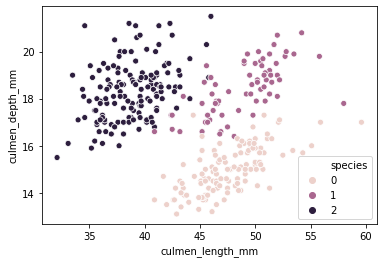

In [ ]:
# Cargo el dataset y borro los NA
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()

# Transformo la columna kind en 2, 1 y 0 y la casteo a int.
penguins['species'] = penguins['species'].str.replace(r"Adelie", "2")
penguins['species'] = penguins['species'].str.replace(r"Chinstrap", "1")
penguins['species'] = penguins['species'].str.replace(r"Gentoo", "0")
penguins['species'] = penguins['species'].astype(int)

penguins_plot = sns.scatterplot(x="culmen_length_mm", y="culmen_depth_mm", hue="species",
                     data=penguins)

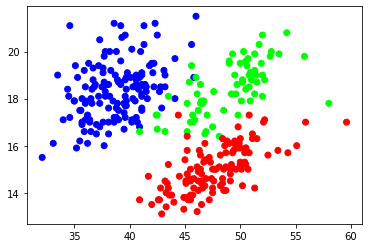

In [ ]:
# Transformo los datos, de manera que puedan ser una entrada válida a nuestros modelos de clasificación.

X_penguins = []
x_pen = []
y_pen = []
T_penguins = []

for i in range(penguins.shape[0]): #Number of rows
  tupla = [penguins.iat[i,2], penguins.iat[i,3]]
  X_penguins.append(tupla)
  x_pen.append(penguins.iat[i,2])
  y_pen.append(penguins.iat[i,3])
  if penguins.iat[i,0] == 0:
    T_penguins.append([1,0,0])
  if penguins.iat[i,0] == 1:
    T_penguins.append([0,1,0])
  if penguins.iat[i,0] == 2:
    T_penguins.append([0,0,1])

plt.scatter(x_pen, y_pen, c=T_penguins)
plt.show()

In [ ]:
# Divido en training y test

X_penguins_train, X_penguins_test, T_penguins_train, T_penguins_test = train_test_split(X_penguins, T_penguins, test_size=0.33, random_state=42)

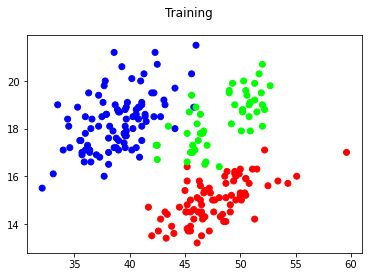

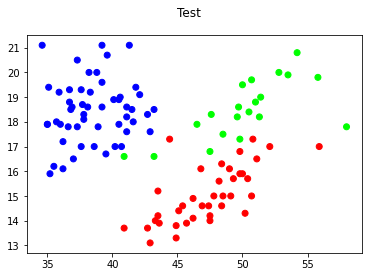

In [ ]:
x_pen_train = []
y_pen_train = []

for i in range(len(X_penguins_train)):
  x_pen_train.append(X_penguins_train[i][0])
  y_pen_train.append(X_penguins_train[i][1])

plt.scatter(x_pen_train, y_pen_train, c=T_penguins_train)
plt.suptitle('Training')
plt.show()

x_pen_test = []
y_pen_test = []

for i in range(len(X_penguins_test)):
  x_pen_test.append(X_penguins_test[i][0])
  y_pen_test.append(X_penguins_test[i][1])

plt.scatter(x_pen_test, y_pen_test, c=T_penguins_test)
plt.suptitle('Test')
plt.show()

# Todo esto es solo para mostrar los datos de training y de test. Lo hago solo para este dataset.

Luego de todo la adaptación de los datos para que cumplan con los formatos que nuestros modelos aceptan, paso a entrenar y testear cada modelo. El primero va a ser el **clasificador por cuadrados mínimos**

### Clasificador por cuadrados minimos

Mal clasificados 5


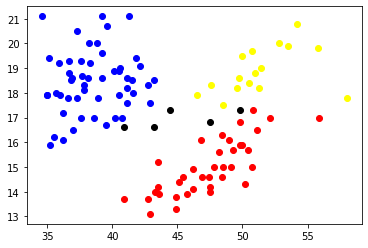

In [ ]:
W_penguins = matriz_W(np.array(X_penguins_train), np.array(T_penguins_train))

mal_clasificados = 0
for x, t in zip(X_penguins_test, T_penguins_test):
  y = y_predictor(W_penguins, x)
  if perceptron(y) != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  if perceptron(y) == perceptron(t) and perceptron(y) == 0:
    plt.scatter(x[0], x[1], c="red")
  if perceptron(y) == perceptron(t) and perceptron(y) == 1:
    plt.scatter(x[0], x[1], c="yellow")
  if perceptron(y) == perceptron(t) and perceptron(y) == 2:
    plt.scatter(x[0], x[1], c="blue")
  

print("Mal clasificados %d" % mal_clasificados)

El último gráfico es el resultado de aplicar el **Clasificador por cuadrados mínimos** en los casos de test. El resultado es bueno, con solo 5 casos de malas clasificaciones. De cierto modo, el resultado era también esperado, ya que son linealmente separables.
Luego de poner a prueba el clasificador por cuadrados mínimos, usaremos **k-means** (salteamos regresión logistica, ya que es aplicable a casos de solo dos clases).

### K-means


Done 43 iterations
[[37.8301204819277, 17.909638554216865], [49.45492957746478, 16.635211267605634], [44.33749999999999, 15.936111111111106]]


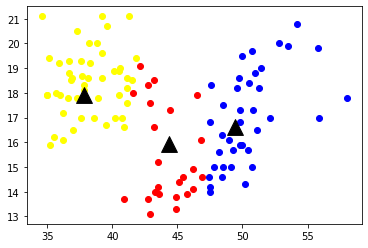

In [ ]:
np.random.seed(1000)

centros_penguins_train = k_means(np.array(X_penguins_train), 3)
print(centros_penguins_train)
mostrar_triclase(centros_penguins_train, X_penguins_test)

72
0.6771300448430493
{0: 2, 1: 1, 2: 0}


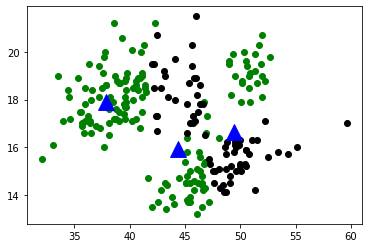

In [ ]:
mostrar_clasificacion(X_penguins_train, T_penguins_train, 3, centros_penguins_train)

La asignacion que esta arriba muestra que el metodo para este caso tiene una eficacia del 67% aproximadamente.

Este resultado es, nuevamente, esperado. Esto se debe a que, al clasificar usando la distancia de los puntos y los centros encontrados como principal herramienta, este clasificador "sufre" cuando las variables aleatorias tienen desvios altos (causando outliers) y/o cuando se solapan las clases, y ambas dos suceden en este data set.

Además, la ubicacion de las medias esta *muy* sujeta a la condición inicial, para eso veamos los siguientes gráficos:

Done 30 iterations
[[39.475949367088596, 17.967088607594935], [33.49523809523809, 16.53333333333333], [47.789682539682524, 16.257142857142853]]


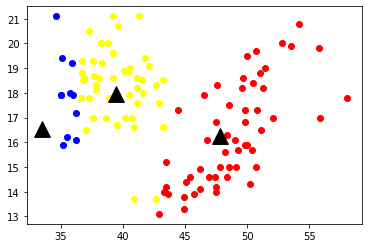

In [ ]:
np.random.seed(0)

centros_penguins_train2 = k_means(np.array(X_penguins_train), 3)
print(centros_penguins_train2)
mostrar_triclase(centros_penguins_train2, X_penguins_test)

76
0.6591928251121076
{0: 2, 1: 1, 2: 0}


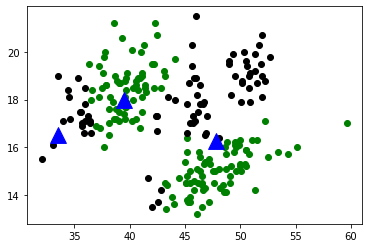

In [ ]:
mostrar_clasificacion(X_penguins_train, T_penguins_train, 3, centros_penguins_train2)

Es claro que este proceso se puede repetir, y dependiendo de las condiciones iniciales, encontrar mucho mejores resultados.

También se puede ver que una mayor cantidad de iteraciones, si las condiciones iniciales son "malas", pueden mejorar el asunto.

Done 10 iterations
[[38.41052631578947, 17.904210526315783], [47, 64], [47.64999999999999, 16.262307692307687]]


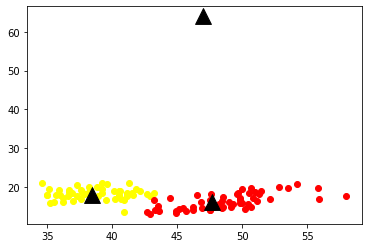

In [ ]:
np.random.seed(0)

centros_penguins_train3 = k_means(np.array(X_penguins_train), 3, maxiter=10)
print(centros_penguins_train3)
mostrar_triclase(centros_penguins_train3, X_penguins_test)

Done 30 iterations
[[39.475949367088596, 17.967088607594935], [33.49523809523809, 16.53333333333333], [47.789682539682524, 16.257142857142853]]


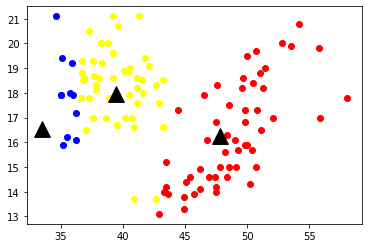

In [ ]:
np.random.seed(0)

centros_penguins_train3 = k_means(np.array(X_penguins_train), 3, maxiter=30)
print(centros_penguins_train3)
mostrar_triclase(centros_penguins_train3, X_penguins_test)

## **Iris**

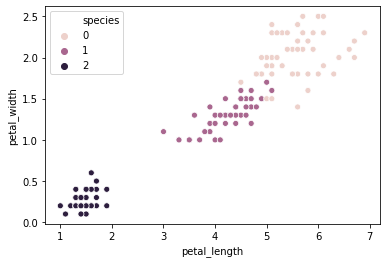

In [ ]:
# Cargo el dataset y borro los NA
iris = sns.load_dataset("iris")
iris = iris.dropna()

# Transformo la columna kind en 2, 1 y 0 y la casteo a int.
iris['species'] = iris['species'].str.replace(r"setosa", "2")
iris['species'] = iris['species'].str.replace(r"versicolor", "1")
iris['species'] = iris['species'].str.replace(r"virginica", "0")
iris['species'] = iris['species'].astype(int)

iris_plot = sns.scatterplot(x="petal_length", y="petal_width", hue="species",
                     data=iris)

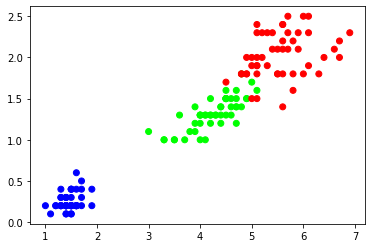

In [ ]:
# Transformo los datos, de manera que puedan ser una entrada válida a nuestros modelos de clasificación.

X_iris = []
x_ir = []
y_ir = []
T_iris = []

for i in range(iris.shape[0]): #Number of rows
  tupla = [iris.iat[i,2], iris.iat[i,3]]
  X_iris.append(tupla)
  x_ir.append(iris.iat[i,2])
  y_ir.append(iris.iat[i,3])
  if iris.iat[i,4] == 0:
    T_iris.append([1,0,0])
  if iris.iat[i,4] == 1:
    T_iris.append([0,1,0])
  if iris.iat[i,4] == 2:
    T_iris.append([0,0,1])

plt.scatter(x_ir, y_ir, c=T_iris)
plt.show()

In [ ]:
# Divido en training y test

X_iris_train, X_iris_test, T_iris_train, T_iris_test = train_test_split(X_iris, T_iris, test_size=0.33, random_state=42)

#### Clasificador cuadratico

Mal clasificados 10


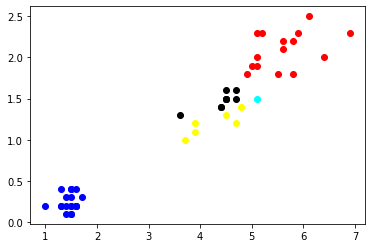

In [ ]:
W_iris = matriz_W(np.array(X_iris_train), np.array(T_iris_train))

mal_clasificados = 0
for x, t in zip(X_iris_test, T_iris_test):
  y = y_predictor(W_iris, x)
  if perceptron(y) != perceptron(t) and perceptron(y) == 0:
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  if perceptron(y) != perceptron(t) and perceptron(y) == 1:
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="CYAN")
  if perceptron(y) == perceptron(t) and perceptron(y) == 0:
    plt.scatter(x[0], x[1], c="red")
  if perceptron(y) == perceptron(t) and perceptron(y) == 1:
    plt.scatter(x[0], x[1], c="yellow")
  if perceptron(y) == perceptron(t) and perceptron(y) == 2:
    plt.scatter(x[0], x[1], c="blue")
  

print("Mal clasificados %d" % mal_clasificados)

En este caso se puede ver claramente cuando el clasificador funciona bien y cuando no. En el caso de la clase azul no cometió ningún fallo, entre la clase roja y amarilla si tuvo inconvenientes, ya que estas dos clases están superpuestas.

ACLARACIÓN: Los puntos negros indican a los puntos que pertenecen a la clase roja, pero son clasificados como amarillos, y los Cyan pertenecen a la clase amarilla y los clasifica como rojos.

No esperamos un resultado muy diferente en K-means.

### K-means

Done 70 iterations
[[1.41875, 0.24062500000000006], [5.537037037037037, 1.9999999999999998], [4.243181818181818, 1.368181818181818]]


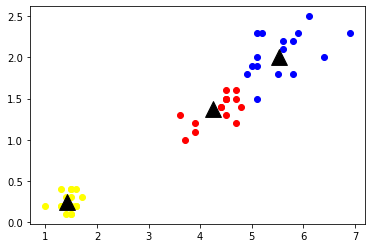

In [ ]:
np.random.seed(100)

centros_iris = k_means(np.array(X_iris_train), 3, maxiter=70)
print(centros_iris)
mostrar_triclase(centros_iris, X_iris_test)

0
1.0
{0: 2, 1: 0, 2: 1}


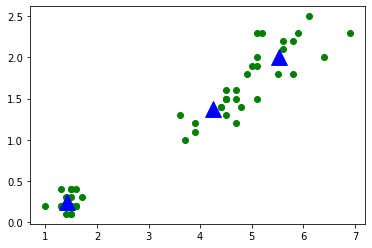

In [ ]:
mostrar_clasificacion(X_iris_test, T_iris_test, 3, centros_iris)

Esperabamos peores resultados, veamos que ocurre cuando cambiamos las condiciones iniciales.

Done 100 iterations
[[4.828985507246377, 1.6391304347826081], [1.4666666666666663, 0.2666666666666666], [55, 28]]


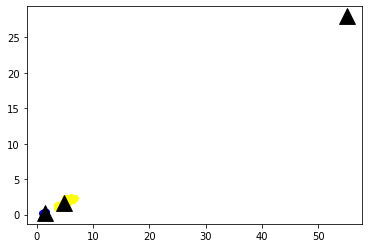

In [ ]:
np.random.seed(45468977)

centros_iris2 = k_means(np.array(X_iris_train), 3, maxiter=100)
print(centros_iris2)
mostrar_triclase(centros_iris2, X_iris_test)

Done 238 iterations
[[5.351282051282051, 1.9179487179487176], [1.41875, 0.24062500000000006], [3.9843749999999996, 1.2312499999999997]]


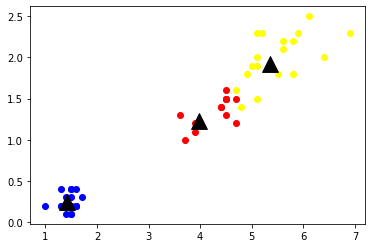

In [ ]:
np.random.seed(45468977)

centros_iris22 = k_means(np.array(X_iris_train), 3, maxiter=1000)
print(centros_iris22)
mostrar_triclase(centros_iris22, X_iris_test)

2
0.96
{0: 0, 1: 2, 2: 1}


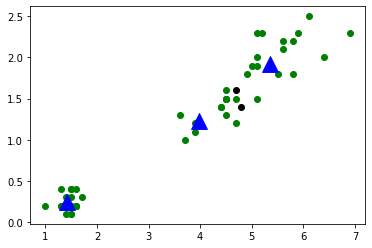

In [ ]:
mostrar_clasificacion(X_iris_test, T_iris_test, 3, centros_iris22)

Efectivamente NO es insalvable (en general) el peso de la condicion inicial en la prediccion. Pero en muchos casos, permite que el metodo sea efectivo vs no serlo.

Parece importante usar alguna heuristica para elegir los puntos iniciales, que sea mas inteligente y evite tener que hacer muchas iteraciones o directamente hacer que no estime bien.

## **Geyser**

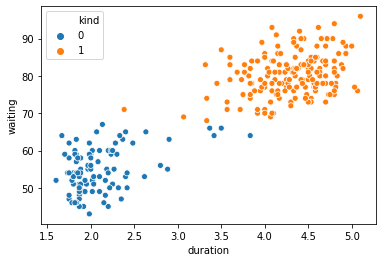

In [ ]:
# Cargo el dataset
geyser = sns.load_dataset("geyser")

# Borro los NA (A efectos prácticos no debería ser problema para lo que vamos a usar el ds)
geyser = geyser.dropna()

# Transformo la columna kind en 1 y 0 (1 = long, 0 = short) y la casteo a int.
geyser['kind'] = geyser['kind'].str.replace(r"long", "1")
geyser['kind'] = geyser['kind'].str.replace(r"short", "0")
geyser['kind'] = geyser['kind'].astype(int)

iris_plot = sns.scatterplot(x="duration", y="waiting", hue="kind",
                     data=geyser)

In [ ]:
# Transformo los datos, de manera que puedan ser una entrada válida a nuestros modelos de clasificación.

X_geyser = []
x_gey = []
y_gey = []
T_geyser = []

for i in range(geyser.shape[0]): #Number of rows
  tupla = [geyser.iat[i,0], geyser.iat[i,1]]
  X_geyser.append(tupla)
  x_gey.append(geyser.iat[i,0])
  y_gey.append(geyser.iat[i,1])
  if geyser.iat[i,2] == 0:
    T_geyser.append([1,0])
  if geyser.iat[i,2] == 1:
    T_geyser.append([0,1])

Paso a probar los modelos, en este caso sumando la regresión logística. Espero buenos resultados de los tres modelos, ya que las clases son distantes y facilmente separables.

In [ ]:
# Divido en training y test
np.random.seed(100)

X_geyser_train, X_geyser_test, T_geyser_train, T_geyser_test = train_test_split(X_geyser, T_geyser, test_size=0.33, random_state=42)

Mal clasificados 1


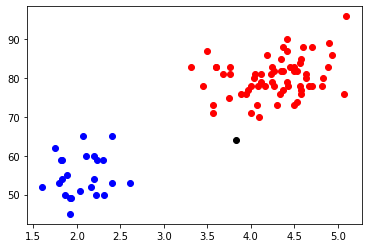

In [ ]:
W_geyser = matriz_W(np.array(X_geyser_train), np.array(T_geyser_train))

mal_clasificados = 0
for x, t in zip(X_geyser_test, T_geyser_test):
  y = y_predictor(W_geyser, x)
  if perceptron(y) != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  if perceptron(y) == perceptron(t) and perceptron(y) == 0:
    plt.scatter(x[0], x[1], c="blue")
  if perceptron(y) == perceptron(t) and perceptron(y) == 1:
    plt.scatter(x[0], x[1], c="red")
  

print("Mal clasificados %d" % mal_clasificados)

Podemos ver lo bien que funciona en este caso el clasificador lineal, y esto se explica combinando un poco todas las explicaciones anteriores. La clases son linealmente separables, por lo tanto es muy fácil para este clasificador conseguir buenos resultados.

Continuo con la **regresión logística**, que será testeada por primera vez en un caso general.

Done 1000 iterations
Mal clasificados 0


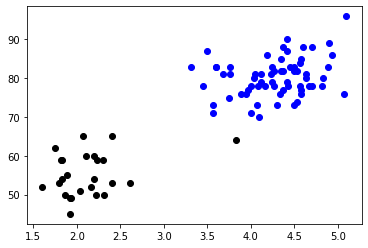

In [ ]:
T_geyser_train_transformed = np.array([[perceptron(t)] for t in T_geyser_train])
np.random.seed(100)

logistica_geyser, _ = get_clasificador_logistico(np.array(X_geyser_train), T_geyser_train_transformed, phi_lineal, maxiter=1000)

mal_clasificados = 0
for x, t in zip(X_geyser_test, T_geyser_test):
  estimacion = logistica_geyser(x)
  if estimacion != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="red")
  else:
    if estimacion == 0:
      plt.scatter(x[0], x[1], c="black")
    if estimacion == 1:
      plt.scatter(x[0], x[1], c="blue")
  
print(f"Mal clasificados {mal_clasificados}")

Se puede ver que consigue clasificar a todos los puntos correctamente, incluso el outlier azul. Veamos que pasa con K-means.

Done 12 iterations
[[4.2508623853211, 79.41284403669725], [2.0542133333333332, 53.68]]


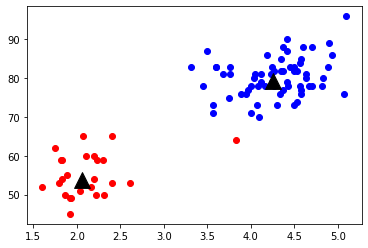

In [ ]:
np.random.seed(100)

centros_geyser_train = k_means(np.array(X_geyser_train), 2)
print(centros_geyser_train)

for x_test in X_geyser_test:
  distancia = [np.linalg.norm(np.array(x_test)-centros_geyser_train[0]),np.linalg.norm(np.array(x_test)-centros_geyser_train[1])]
  distancia_centro = np.argmin(distancia)
  if distancia_centro == 0:
    plt.scatter(x_test[0], x_test[1], c="blue")
  if distancia_centro == 1:
    plt.scatter(x_test[0], x_test[1], c="red")

plt.scatter(centros_geyser_train[0][0], centros_geyser_train[0][1], s=250, marker='^', c="black")
plt.scatter(centros_geyser_train[1][0], centros_geyser_train[1][1], s=250, marker='^', c="black")

Clasificó a todos bien. Honestamente, K-means no deja de sorprenderme, en todos los data sets esperaba peores resultados.

Da la impresión de que el clasificador logístico, si son linealmente separables las clases, en muy pocas iteraciones encuentra el hiperplano que las separa resultado significativamente más general que los otros métodos explorado.

**Conclusiones:**

*   *Cuadrático*: Funciona bien solo bajo condición de que las clases sean linealmente separables. Dependiendo de cuan importante sea el error, puede también ser aceptable su consideración cuando las clases están minimamente solapadas.
*   *K-means*: Depende mucho de como se inicializan los centros, a veces en pocas iteraciones se consiguen resultados significativamente mejores que para más iteraciones. Podría ser complementario elegir un método para determinar los centros. Es liviano. En general proporciona un estimado razonable de centros de la clases.
*   *Logística*: Es pesado, en general a mas iteraciones clasifica mejor. Da la posibilidad de cambiar la basis function y clasificar clases que no sean linealmente separables (Análisis siguiente).

# **Análisis en casos de elipses**

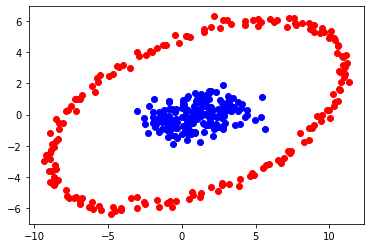

In [ ]:
np.random.seed(100)

N = 180    # N es la cantidad de datos POR CLASE
t = np.linspace(0, 2*np.pi, N)
a_1 = 10  # Determina el diametro horizontal
b_1 = 6   # Determina el diametro vertical
x_1 = a_1 * np.cos(t) + 0.2*np.random.normal(size=N) + 1 
y_1 = b_1 * np.sin(t+0.5) + 0.2*np.random.normal(size=N)  
plt.scatter(x_1, y_1, c="red")

a_2 = 2   # Determina el diametro horizontal
b_2 = 0.8   # Determina el diametro vertical
x_2 = a_2 *np.cos(t) + 1*np.random.normal(size=N) + 1
y_2 = b_2 *np.sin(t+0.5) + 0.5*np.random.normal(size=N)
plt.scatter(x_2, y_2, c="blue")

X_elipse = [] # Datos transformados a nuestro formato
T_elipse = [] # Datos asignados a una clase (codificación 1-k)
for X,T in zip(x_1,y_1):
  X_elipse.append([X,T])
  T_elipse.append([1,0])

for X,T in zip(x_2,y_2):
  X_elipse.append([X,T])
  T_elipse.append([0,1])

X_elipse_train, X_elipse_test, T_elipse_train, T_elipse_test = train_test_split(X_elipse, T_elipse, test_size=0.33, random_state=42)

T_elipse_train_transformed = np.array([[perceptron(t)] for t in T_elipse_train])

Primeramente, vamos a usar el clasificador logístico usando una basis function lineal. Esperamos que los resultados sean malos.

Done 100 iterations
Mal clasificados 62


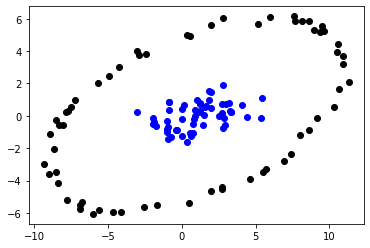

In [ ]:
logistica_elipse, _ = get_clasificador_logistico(np.array(X_elipse_train), T_elipse_train_transformed, phi_lineal, maxiter=100)

mal_clasificados = 0
for x, t in zip(X_elipse_test, T_elipse_test):
  estimacion = logistica_elipse(x)
  if estimacion != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  else:
    if estimacion == 0:
      plt.scatter(x[0], x[1], c="red")
    if estimacion == 1:
      plt.scatter(x[0], x[1], c="blue")
  
print(f"Mal clasificados {mal_clasificados}")

Como se pudo comprobar, los resultados no son buenos. Veamos ahora que pasa cuando cambiamos la basis function a una elíptica con *pocas* iteraciones:

Done 100 iterations
Mal clasificados 3


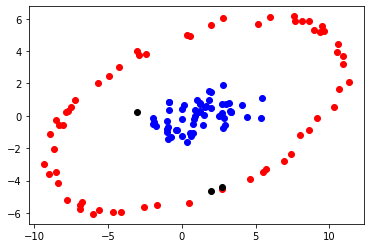

In [ ]:
def phi_elipse(x):
  return np.array([1, x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

np.random.seed(100)

logistica_elipse, _ = get_clasificador_logistico(np.array(X_elipse_train), T_elipse_train_transformed, phi_elipse, maxiter=100)

mal_clasificados = 0
for x, t in zip(X_elipse_test, T_elipse_test):
  estimacion = logistica_elipse(x)
  if estimacion != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  else:
    if estimacion == 0:
      plt.scatter(x[0], x[1], c="red")
    if estimacion == 1:
      plt.scatter(x[0], x[1], c="blue")
  
print(f"Mal clasificados {mal_clasificados}")

Vemos que la basis function inicial elegida, SI tiene influencia en el resultado; 

*Hipótesis:* A mayores iteraciones el peso de ese $w_0$ disminuye y se acerca simpre a la mejor solución.

Probamos el clasificador logístico usando la basis function elíptica con *muchas* iteraciones:

Done 1000 iterations
Mal clasificados 0


0


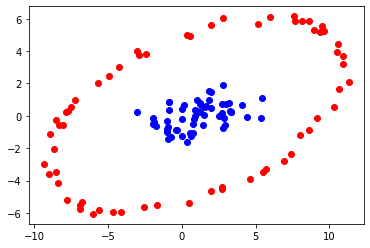

In [ ]:
np.random.seed(100)

logistica_elipse, iter_info = get_clasificador_logistico(np.array(X_elipse_train), T_elipse_train_transformed, phi_elipse, maxiter=1000)

mal_clasificados = 0
for x, t in zip(X_elipse_test, T_elipse_test):
  estimacion = logistica_elipse(x)
  if estimacion != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  else:
    if estimacion == 0:
      plt.scatter(x[0], x[1], c="red")
    if estimacion == 1:
      plt.scatter(x[0], x[1], c="blue")
  
print(f"Mal clasificados {mal_clasificados}")

test_color = []

for j, info in enumerate(iter_info):
  errores = 0
  if (j+1) % 10 != 0:
    continue
  logistic = info["clasificador"]
  for i, x in enumerate(X_elipse_test):
    estimacion = logistic(x)

    color = 'ok'

    clase = perceptron(T_elipse_test[i])
    if estimacion != clase:
      errores += 1
      color = 'error'

    test_color.append({"group": i,"x": x[0], "y":x[1], "clase": clase, "estimacion": estimacion, "clasificacion": color, "iter": j+1})

f = px.scatter(test_color, x="x", y="y", color="clasificacion", animation_frame="iter", animation_group="group", range_x=[0, 100], range_y=[0, 100])
f.show()

print(errores)

Vemos que efectivamente, clasifica mejor a más iteraciones.

Ahora vamos a probar que pasa cuando es aplicado el clasificador logístico usando una $\phi$ elíptica para clases linealmente separables (DataSet usado anteriormente: Geyser).

Done 100 iterations
Mal clasificados 1


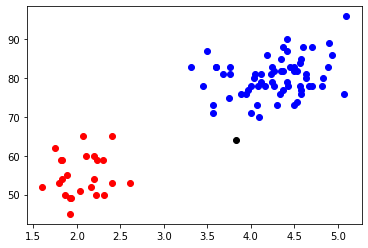

In [ ]:
np.random.seed(100)

logistica_geyser, iter_info = get_clasificador_logistico(np.array(X_geyser_train), T_geyser_train_transformed, phi_elipse, maxiter=100)

mal_clasificados = 0
for x, t in zip(X_geyser_test, T_geyser_test):
  estimacion = logistica_geyser(x)
  if estimacion != perceptron(t):
    mal_clasificados += 1
    plt.scatter(x[0], x[1], c="black")
  else:
    if estimacion == 0:
      plt.scatter(x[0], x[1], c="red")
    if estimacion == 1:
      plt.scatter(x[0], x[1], c="blue")
  
print(f"Mal clasificados {mal_clasificados}")

test_color = []

for j, info in enumerate(iter_info):
  errores = 0
  if (j+1) % 10 != 0:
    continue
  logistic = info["clasificador"]
  for i, x in enumerate(X_geyser_test):
    estimacion = logistic(x)

    color = 'ok'

    clase = perceptron(T_geyser_test[i])
    if estimacion != clase:
      errores += 1
      color = 'error'

    test_color.append({"group": i,"x": x[0], "y":x[1], "clase": clase, "estimacion": estimacion, "clasificacion": color, "iter": j+1})

f = px.scatter(test_color, x="x", y="y", color="clasificacion", animation_frame="iter", animation_group="group", range_x=[0, 100], range_y=[0, 100])
f.show()

Vemos que encontrar una phi adecuada no es impresidible (si toleramos un poco de error) pero si muy recomendable y ahorra mucho trabajo.